# UCI - Human Action Recognition - CNN-LSTM

### `import` statements

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf  # Import TensorFlow
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, Dropout, Flatten,
    LSTM, TimeDistributed, Dense )
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import classification_report as cr

### Set random generator seed

In [2]:
# Set random seed
np.random.seed(42)

In [3]:
# Data directory
DATADIR = '/Users/alesandrawiecheckivergara/Desktop/PR/ICP/human+activity+recognition+using+smartphones/UCI HAR Dataset'

# Signals to load
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

activity_map = {
    0: "Walking",
    1: "Walking Upstairs",
    2: "Walking Downstairs",
    3: "Sitting",
    4: "Standing",
    5: "Laying"
}

### Utility Functions to load and process dataset

In [4]:
# Utility function to read CSV files
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Function to load signal data
def load_signals(subset):
    signals_data = []
    for signal in SIGNALS:
        filename = f'{DATADIR}/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(_read_csv(filename).to_numpy())
    return np.transpose(signals_data, (1, 2, 0))  # Shape: (samples, timesteps, signals)

# Function to load labels
def load_y(subset):
    filename = f'{DATADIR}/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]
    return pd.get_dummies(y).to_numpy()  # One-hot encoded labels

# Function to load the entire dataset
def load_data():
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')
    return X_train, X_test, y_train, y_test

### Load the dataset

In [5]:
# Load the dataset
X_train, X_test, Y_train, Y_test = load_data()

# Print dataset shapes
print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")

# Convert one-hot labels to class indices
Y_train = np.argmax(Y_train, axis=1)
Y_test = np.argmax(Y_test, axis=1)

# Verify the shapes after conversion
print(f"Y_train shape after conversion: {Y_train.shape}")
print(f"Y_test shape after conversion: {Y_test.shape}")

X_train shape: (7352, 128, 9), Y_train shape: (7352, 6)
X_test shape: (2947, 128, 9), Y_test shape: (2947, 6)
Y_train shape after conversion: (7352,)
Y_test shape after conversion: (2947,)


### Reshape the data for CNN-LSTM

In [6]:
# Reshape the data for CNN-LSTM
n_steps, n_length = 4, 32  # Define steps and length per step
input_dim = X_train.shape[-1]  # Number of features (signals)
n_classes = len(np.unique(Y_train))  # Number of unique classes

# Reshape input into [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], n_steps, n_length, input_dim))
X_test = X_test.reshape((X_test.shape[0], n_steps, n_length, input_dim))

# Print reshaped dataset shapes
print(f"X_train reshaped: {X_train.shape}")
print(f"X_test reshaped: {X_test.shape}")

X_train reshaped: (7352, 4, 32, 9)
X_test reshaped: (2947, 4, 32, 9)


## Define the CNN-LSTM model

In [17]:
# Define the CNN-LSTM model
n_hidden = 64  # Number of LSTM hidden units
epochs = 500
batch_size = 64
dropout_rate = 0.25
patience = 15

model2 = Sequential()
model2.add(TimeDistributed(Conv1D(filters=128, kernel_size=3, activation='relu'), input_shape=(n_steps, n_length, input_dim)))
model2.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model2.add(TimeDistributed(Dropout(2*dropout_rate)))
model2.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model2.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model2.add(TimeDistributed(Dropout(2*dropout_rate)))
model2.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model2.add(TimeDistributed(Dropout(dropout_rate)))
model2.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model2.add(TimeDistributed(Flatten()))
model2.add(LSTM(n_hidden))
model2.add(Dropout(dropout_rate))
model2.add(Dense(n_hidden, activation='relu'))
model2.add(Dense(n_classes, activation='softmax'))

# Compile the model
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/Users/alesandrawiecheckivergara/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Model Summary

In [18]:
model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_20             │ (None, 4, 30, 128)     │         3,584 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_21             │ (None, 4, 15, 128)     │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_22             │ (None, 4, 15, 128)     │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_23             │ (None, 4, 13, 64)      │        24,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_24             │ (None, 4, 6, 64)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_25             │ (None, 4, 6, 64)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_26             │ (None, 4, 4, 64)       │        12,352 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_27             │ (None, 4, 4, 64)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_28             │ (None, 4, 2, 64)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_29             │ (None, 4, 128)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,534 (369.27 KB)

 Trainable params: 94,534 (369.27 KB)

 Non-trainable params: 0 (0.00 B)

### Train model

In [12]:
# Train the model
history = model2.fit(
    X_train, Y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, Y_test),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)]
)

Epoch 1/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.5305 - loss: 1.1604 - val_accuracy: 0.7139 - val_loss: 0.6977
Epoch 2/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8286 - loss: 0.4154 - val_accuracy: 0.8120 - val_loss: 0.5535
Epoch 3/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.9004 - loss: 0.2521 - val_accuracy: 0.8286 - val_loss: 0.5214
Epoch 4/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9281 - loss: 0.1896 - val_accuracy: 0.8731 - val_loss: 0.3862
Epoch 5/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9462 - loss: 0.1466 - val_accuracy: 0.8856 - val_loss: 0.3900
Epoch 6/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.9465 - loss: 0.1373 - val_accuracy: 0.8612 - val_loss: 0.4026
Epoch 7/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.9459 - loss: 0.1367 - val_accuracy: 0.8931 - val_loss: 0.3605
Epoch 8/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9510 - loss: 0.1251 - val_accu

### Plot training history

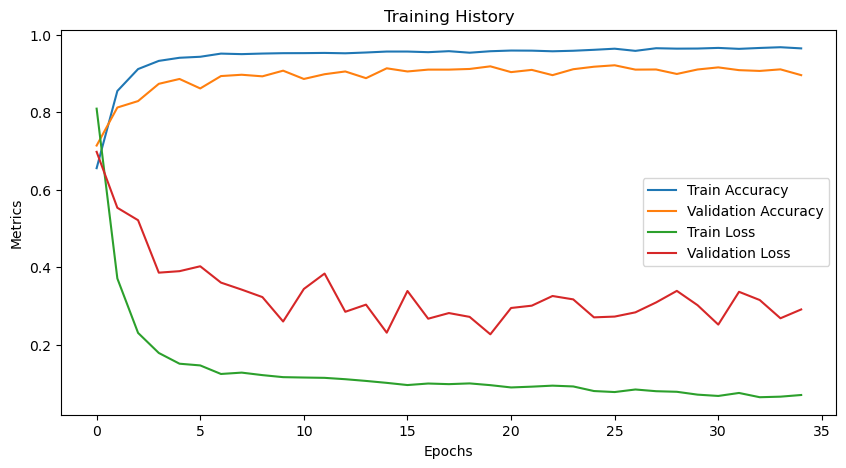

In [13]:
# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.legend()
    plt.title('Training History')
    plt.show()
    
plot_training_history(history)

### Evaluate the model

In [14]:
# Evaluate the model
test_loss, test_accuracy = model2.evaluate(X_test, Y_test, batch_size=batch_size)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8683 - loss: 0.2887
Test Accuracy: 91.82%


### Confusion Matrix

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


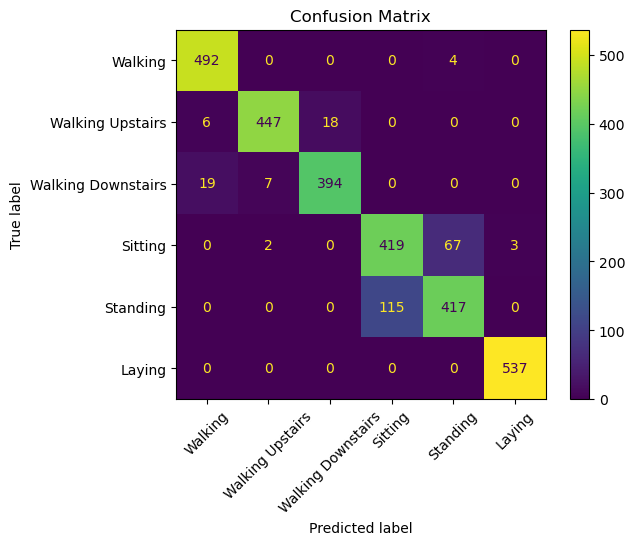

In [15]:
# Confusion Matrix
y_pred = np.argmax(model2.predict(X_test), axis=1)
conf_matrix = cm(Y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=list(activity_map.values()))
disp.plot(cmap='viridis', xticks_rotation=45)
plt.title('Confusion Matrix')
plt.show()

### Classification Report

In [16]:
print(cr(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       496
           1       0.98      0.95      0.96       471
           2       0.96      0.94      0.95       420
           3       0.78      0.85      0.82       491
           4       0.85      0.78      0.82       532
           5       0.99      1.00      1.00       537

    accuracy                           0.92      2947
   macro avg       0.92      0.92      0.92      2947
weighted avg       0.92      0.92      0.92      2947

